# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Data

In [2]:
# import train and test dataset
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
# training dataset
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# test dataset
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# looking for missing values
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


# EDA

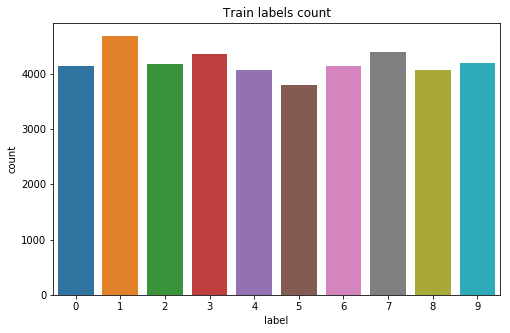

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(train['label'])
plt.title('Train labels count')
plt.show()

In [7]:
train['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

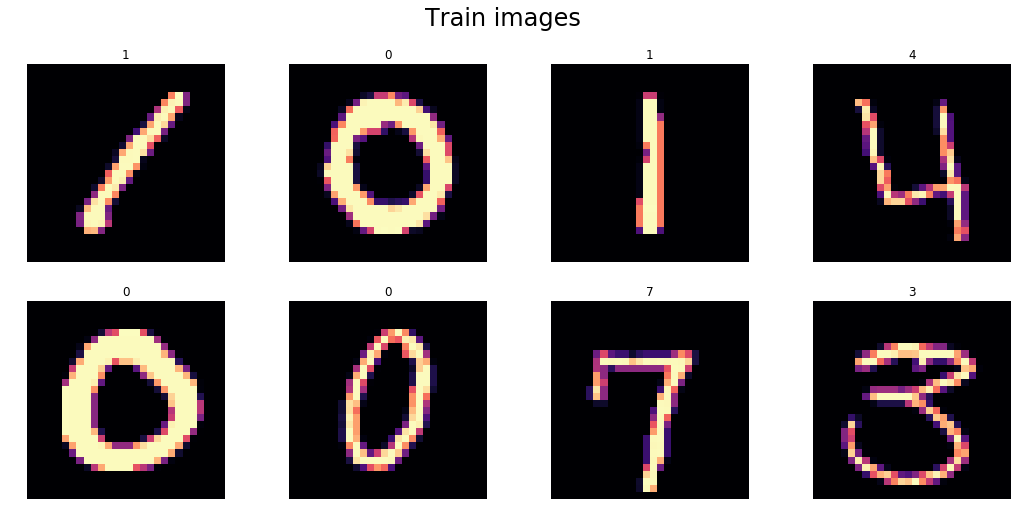

In [8]:
# first few train images with labels
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in train.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    plt.title(row[0])
    img = row.to_numpy()[1:].reshape(28, 28)
    fig.suptitle('Train images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

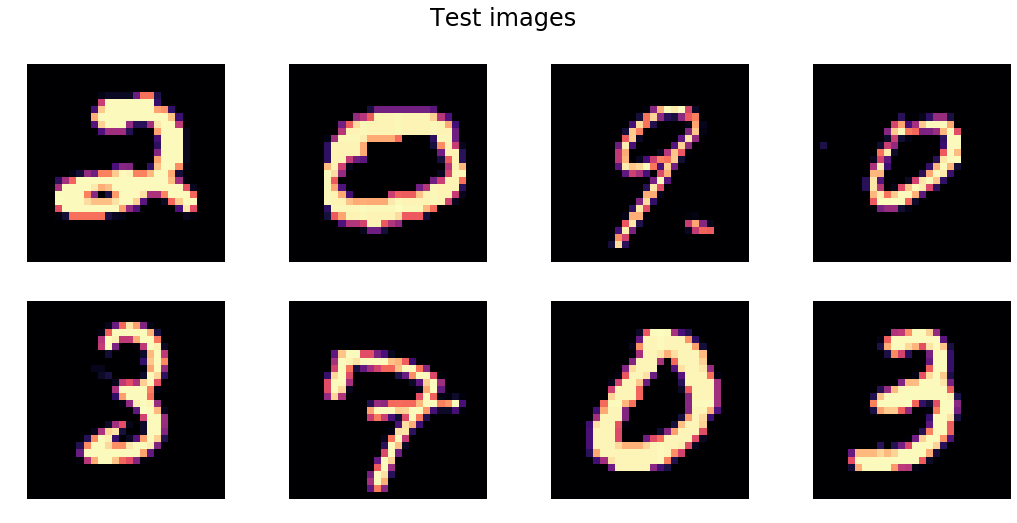

In [9]:
# first few test images
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in test.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    img = row.to_numpy()[:].reshape(28, 28)
    fig.suptitle('Test images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

# Preprocessing

In [10]:
# split into image and labels and convert to numpy array
X = train.iloc[:, 1:].to_numpy()
y = train['label'].to_numpy()

# test dataset
test = test.loc[:, :].to_numpy()

for i in [X, y, test]:
    print(i.shape)

(42000, 784)
(42000,)
(28000, 784)


In [11]:
# normalize the data
# ==================

X = X / 255.0
test = test / 255.0

In [12]:
# reshape dataset
# ===============

# shape of training and test dataset
print(X.shape)
print(test.shape)

# reshape the dataframe to 3x3 matrix with 1 channel grey scale values
X = X.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

# shape of training and test dataset
print(X.shape)
print(test.shape)

(42000, 784)
(28000, 784)
(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [13]:
# one hot encode target
# =====================

# shape and values of target
print(y.shape)
print(y[0])

# convert Y_train to categorical by one-hot-encoding
y_enc = to_categorical(y, num_classes = 10)

# shape and values of target
print(y_enc.shape)
print(y_enc[0])

(42000,)
1
(42000, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# train test split
# ================

# random seed
random_seed = 2

# train validation split
X_train, X_val, y_train_enc, y_val_enc = train_test_split(X, y_enc, test_size=0.2)

# shape
for i in [X_train, y_train_enc, X_val, y_val_enc]:
    print(i.shape)

(33600, 28, 28, 1)
(33600, 10)
(8400, 28, 28, 1)
(8400, 10)


## Plot images

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


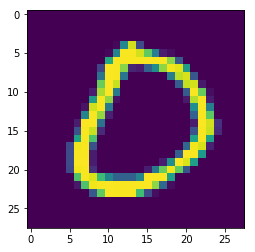

In [15]:
g = plt.imshow(X_train[0][:,:,0])
print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


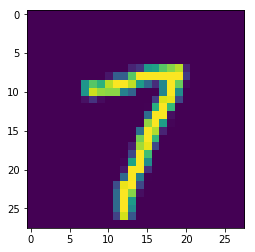

In [16]:
g = plt.imshow(X_train[9][:,:,0])
print(y_train_enc[9])

# CNN

In [17]:
INPUT_SHAPE = (28,28,1)
OUTPUT_SHAPE = 10
BATCH_SIZE = 128
EPOCHS = 10
VERBOSE = 2

### Define CNN Model

In [18]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

### Compile model

In [19]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Model summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

### Model fitting

In [21]:
history = model.fit(X_train, y_train_enc,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=VERBOSE,
                    validation_split=0.3)

Train on 23520 samples, validate on 10080 samples
Epoch 1/10
23520/23520 - 14s - loss: 0.5134 - accuracy: 0.8380 - val_loss: 0.1143 - val_accuracy: 0.9646
Epoch 2/10
23520/23520 - 13s - loss: 0.1381 - accuracy: 0.9588 - val_loss: 0.0785 - val_accuracy: 0.9742
Epoch 3/10
23520/23520 - 13s - loss: 0.0931 - accuracy: 0.9712 - val_loss: 0.0714 - val_accuracy: 0.9787
Epoch 4/10
23520/23520 - 13s - loss: 0.0725 - accuracy: 0.9782 - val_loss: 0.0528 - val_accuracy: 0.9841
Epoch 5/10
23520/23520 - 13s - loss: 0.0562 - accuracy: 0.9835 - val_loss: 0.0499 - val_accuracy: 0.9850
Epoch 6/10
23520/23520 - 12s - loss: 0.0468 - accuracy: 0.9864 - val_loss: 0.0500 - val_accuracy: 0.9846
Epoch 7/10
23520/23520 - 13s - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.0449 - val_accuracy: 0.9870
Epoch 8/10
23520/23520 - 13s - loss: 0.0358 - accuracy: 0.9890 - val_loss: 0.0441 - val_accuracy: 0.9876
Epoch 9/10
23520/23520 - 13s - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.0433 - val_accuracy: 0.9880
Epoch

### Accurayc and loss

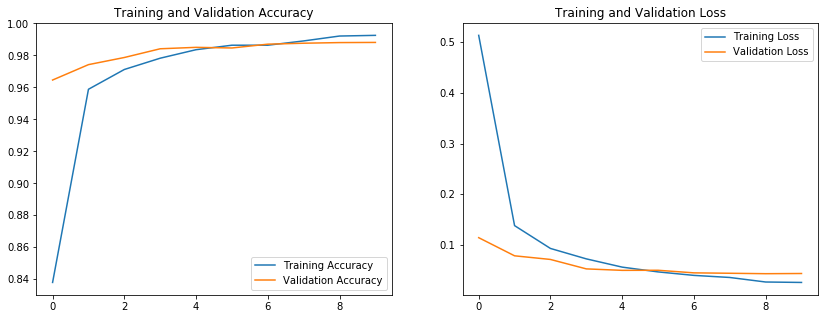

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

### Evaluating on validationa dataset

In [23]:
# model loss and accuracy on validation set
model.evaluate(X_val, y_val_enc, verbose=False)

[0.04411794892793599, 0.98833334]

In [24]:
# predicted values
y_pred_enc = model.predict(X_val)

# actual
y_act = [np.argmax(i) for i in y_val_enc]

# decoding predicted values
y_pred = [np.argmax(i) for i in y_pred_enc]

print(y_pred_enc[0])
print(y_pred[0])

[6.9778815e-07 3.3699482e-05 1.5661481e-05 1.1142810e-06 4.4838399e-07
 1.3806017e-07 1.6911121e-08 9.9991786e-01 5.8969493e-07 2.9857511e-05]
7


In [25]:
print(classification_report(y_act, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.99      1.00      0.99       919
           2       0.99      0.98      0.99       828
           3       0.99      0.99      0.99       865
           4       0.99      0.98      0.99       857
           5       1.00      0.99      0.99       757
           6       0.99      0.99      0.99       828
           7       0.98      0.99      0.98       879
           8       0.98      0.99      0.99       802
           9       0.97      0.99      0.98       804

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



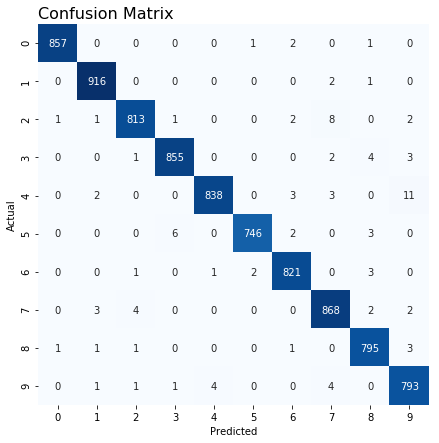

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(y_act, y_pred), annot=True, 
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', loc='left', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Predicting on test

In [27]:
# predicted values
y_pred_enc = model.predict(test)

# decoding predicted values
y_pred = [np.argmax(i) for i in y_pred_enc]

print(y_pred_enc[0])
print(y_pred[0])

[2.2493309e-11 5.8631605e-10 1.0000000e+00 2.5190232e-09 4.3388841e-11
 2.0736258e-13 3.3520624e-11 4.3361851e-08 3.2970185e-10 2.9321016e-12]
2


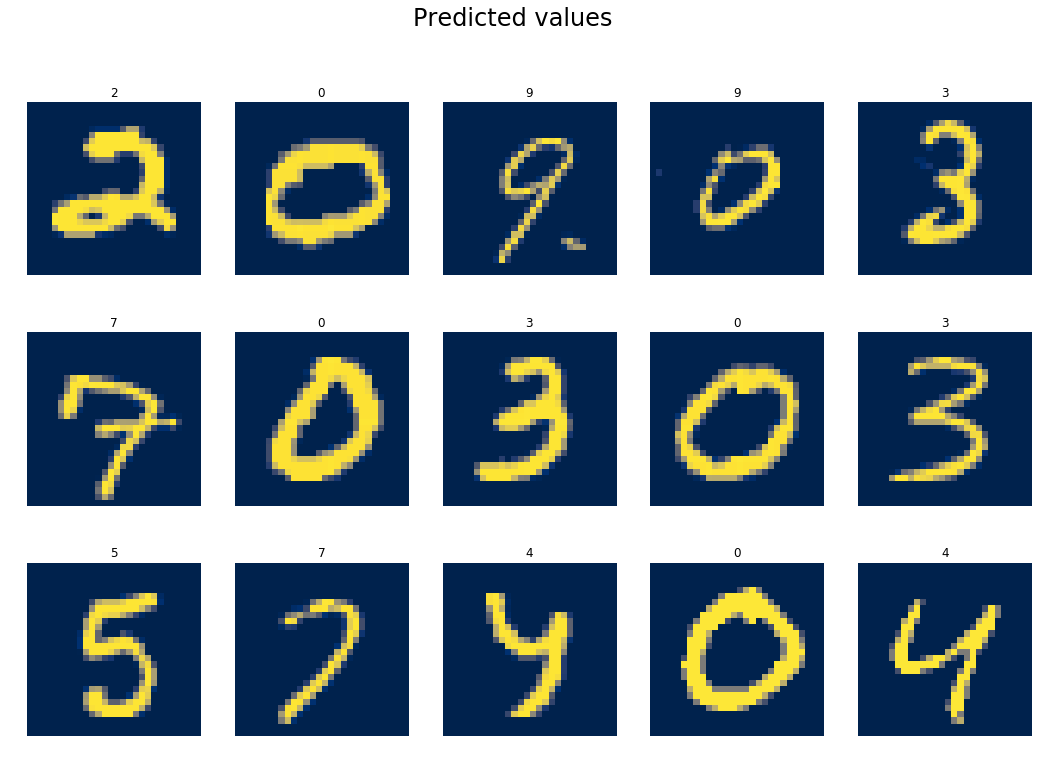

In [28]:
# predicted targets of each images
# (labels above the images are predicted labels)
fig, ax = plt.subplots(figsize=(18, 12))
for ind, row in enumerate(test[:15]):
    plt.subplot(3, 5, ind+1)
    plt.title(y_pred[ind])
    img = row.reshape(28, 28)
    fig.suptitle('Predicted values', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='cividis')